In [1]:
# ==============================
# 0. Create Conda Environment
# ==============================
# แนะนำใช้ Python 3.10
# conda create -n frcnn_env python=3.10 -y
# conda activate frcnn_env

In [ ]:
# ==============================
# 1. Install PyTorch & dependencies
# ==============================
# สำหรับ Windows + GPU (CUDA 11.8)
# conda install pandas matplotlib pytorch torchvision torchaudio cudatoolkit=11.8 -c pytorch -y


# สำหรับ CPU หรือ Mac (Apple Silicon/Intel)
# conda install pandas matplotlib pytorch torchvision torchaudio cpuonly -c pytorch -y

# pip install pycocotools scikit-learn tqdm

In [3]:
# ==============================
# 2. Imports in Python
# ==============================
import os
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from torchvision.datasets import CocoDetection
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision.transforms import functional as F

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# ==============================
# 3. Device setup
# ==============================
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA GPU available.")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

print("Using device:", device)

No GPU available, using CPU.
Using device: cpu


In [5]:
# ==============================
# 4. Custom Function
# ==============================
import torchvision.transforms as T
import torchvision.transforms.functional as F

class ToTensorTarget:
    def __call__(self, image, target):
        return F.to_tensor(image), target

class CocoTargetTransform:
    def __call__(self, image, target):
        """
        target: list of dicts [{'bbox':[x,y,w,h], 'category_id':int, ...}, ...]
        convert to:
        {
          'boxes': Tensor[N,4],
          'labels': Tensor[N]
        }
        """
        boxes = []
        labels = []
        for obj in target:
            x, y, w, h = obj['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(obj['category_id'])
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return F.to_tensor(image), {"boxes": boxes, "labels": labels}
    
class CocoTargetTransformWithAug:
    def __init__(self, augment=False):
        self.augment = augment

    def __call__(self, image, target):
        # --- Augmentation ---
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = F.hflip(image)
                w, h = image.size
                for obj in target:
                    x, y, box_w, box_h = obj['bbox']
                    obj['bbox'][0] = w - x - box_w  # flip x

            # Color jitter
            color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            image = color_jitter(image)

        # --- Convert target ---
        boxes = []
        labels = []
        for obj in target:
            x, y, w, h = obj['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(obj['category_id'])
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return F.to_tensor(image), {"boxes": boxes, "labels": labels}

In [6]:
# ==============================
# 5. Dataset and DataLoader ที่ต้องใช้จริง
# ==============================
dataset_root = "DMD.v7i.coco"  # เปลี่ยน path ตามเครื่องคุณ

train_dataset = CocoDetection(
    root=os.path.join(dataset_root, "train"),
    annFile=os.path.join(dataset_root, "train/_annotations.coco.json"),
    transforms=CocoTargetTransformWithAug(augment=True)
)

val_dataset = CocoDetection(
    root=os.path.join(dataset_root, "valid"),
    annFile=os.path.join(dataset_root, "valid/_annotations.coco.json"),
    transforms=CocoTargetTransformWithAug(augment=False)
)

test_dataset = CocoDetection(
    root=os.path.join(dataset_root, "test"),
    annFile=os.path.join(dataset_root, "test/_annotations.coco.json"),
    transforms=CocoTargetTransformWithAug(augment=False)
)

def collate_fn(batch):
    # batch = [(image, target), (image, target), ...]
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# ==============================
# 5.2 สำหรับทดสอบเท่านั้น
# ==============================
import random
from torch.utils.data import Subset

# ==============================
# กำหนดขนาด subset
# ==============================
train_subset_size = 3000   # ใช้ train แค่ 500 ภาพ
val_subset_size   = 400   # ใช้ val แค่ 100 ภาพ
test_subset_size  = 50   # ใช้ test แค่ 100 ภาพ
random.seed(42) # ตั้ง seed เพื่อ reproducible

# ==============================
# Random subset & overwrite loader เดิม
# ==============================
train_dataset = Subset(train_dataset, random.sample(range(len(train_dataset)), train_subset_size))
val_dataset   = Subset(val_dataset, random.sample(range(len(val_dataset)), val_subset_size))
test_dataset  = Subset(test_dataset, random.sample(range(len(test_dataset)), test_subset_size))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


print(len(train_dataset))  # จำนวนรูปทั้งหมดใน train set
print(len(train_loader))  # จำนวน batch (ขึ้นกับ batch_size)
print(len(val_dataset))  # จำนวนรูปทั้งหมดใน val set
print(len(val_loader))  # จำนวน batch (ขึ้นกับ batch_size)
print(len(test_dataset))  # จำนวนรูปทั้งหมดใน test set
print(len(test_loader))  # จำนวน batch (ขึ้นกับ batch_size)




3000
3000
400
400
50
50


In [8]:
import json
import os

dataset_root = "DMD.v7i.coco"  # path โฟลเดอร์ dataset ของคุณ
json_path = os.path.join(dataset_root, "train", "_annotations.coco.json")  # <- แก้ชื่อไฟล์ให้ตรง

with open(json_path) as f:
    coco = json.load(f)

categories = coco["categories"]
print(f"Number of classes:", len(categories))
for c in categories:
    print(c["id"], c["name"])

Number of classes: 7
0 awake-or-distracted
1 DangerousDriving
2 Distracted
3 Drinking
4 SafeDriving
5 SleepyDriving
6 Yawn


In [9]:
# ==============================
# 6. Model Setup
# ==============================
from torch.optim.lr_scheduler import StepLR


num_classes = 7  # background + drowsiness
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # ลด LR ทุก 3 epoch


In [10]:
# ==============================
# 7. Training + Validation Loop
# ==============================
num_epochs = 2
best_val_loss = float("inf")

for epoch in range(num_epochs):
    # ----- Freeze backbone 2 epoch -----
    if epoch < 2:
        for param in model.backbone.parameters():
            param.requires_grad = False
    else:
        for param in model.backbone.parameters():
            param.requires_grad = True
            
    # ----- Training -----
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Train")
    
    for imgs, targets in loop:
        imgs = list(img.to(device) for img in imgs)

        # Flatten targets (handle list of list)
        flat_targets = []
        for t in targets:
            if isinstance(t, list):
                flat_targets.extend(t)
            else:
                flat_targets.append(t)

        # Skip batch ถ้าไม่มี annotation
        if len(flat_targets) == 0:
            continue

        # Move tensors to device
        flat_targets = [
            {k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} 
            for t in flat_targets
        ]

        loss_dict = model(imgs, flat_targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        loop.set_postfix(batch_loss=losses.item())

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Train Loss: {avg_train_loss:.4f}")

    # ----- Validation -----
    model.train()  # ใช้ train mode เพื่อให้ return loss
    val_loss = 0
    with torch.no_grad():  # ป้องกันการอัปเดต gradient
        for imgs, targets in val_loader:
            imgs = list(img.to(device) for img in imgs)
    
            # Flatten targets
            flat_targets = []
            for t in targets:
                if isinstance(t, list):
                    flat_targets.extend(t)
                else:
                    flat_targets.append(t)
    
            if len(flat_targets) == 0:
                continue
    
            flat_targets = [
                {k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} 
                for t in flat_targets
            ]
    
            # Compute loss without updating weights
            loss_dict = model(imgs, flat_targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Val Loss: {avg_val_loss:.4f}")

    # ----- Save best model -----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_fasterrcnn_drowsiness.pth")
        print(f"Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

print("Training completed.")


Epoch [1/2] Train: 100%|██████████| 3000/3000 [27:51<00:00,  1.80it/s, batch_loss=0.0818]


Epoch [1/2] Average Train Loss: 0.8236
Epoch [1/2] Average Val Loss: 0.6061
Best model saved at epoch 1 with val loss 0.6061


Epoch [2/2] Train: 100%|██████████| 3000/3000 [26:10<00:00,  1.91it/s, batch_loss=0.385] 


Epoch [2/2] Average Train Loss: 0.5317
Epoch [2/2] Average Val Loss: 0.4156
Best model saved at epoch 2 with val loss 0.4156
Training completed.


In [14]:
# ==============================
# 8. Test Evaluation (COCO mAP)
# ==============================
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm
import os

# โหลด COCO annotations ของ test set
cocoGt = COCO(os.path.join(dataset_root, "test/_annotations.coco.json"))

coco_results = []

model.eval()
with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating")
    for batch_idx, (imgs, targets) in enumerate(loop):
        imgs = list(img.to(device) for img in imgs)
        outputs = model(imgs)

        for i, (output, target) in enumerate(zip(outputs, targets)):
            # ใช้ image filename หรือ index เป็น id หาก target ไม่มี image_id
            image_id = target.get("image_id", batch_idx * len(outputs) + i)

            # เตรียมผลลัพธ์ในรูป COCO format
            for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                x1, y1, x2, y2 = box.tolist()
                width = x2 - x1
                height = y2 - y1
                coco_results.append({
                    "image_id": image_id,
                    "category_id": int(label.item()),
                    "bbox": [x1, y1, width, height],
                    "score": float(score.item())
                })

# COCO evaluation (mAP, AP50, AP75)
cocoDt = cocoGt.loadRes(coco_results)
cocoEval = COCOeval(cocoGt, cocoDt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Evaluating: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

In [18]:
import numpy as np

# cocoEval คือ object หลังจาก cocoEval.evaluate() และ accumulate()
# ดึง precision array: [T, R, K, A, M]
# T = IoU thresholds, R = recall thresholds, K = num categories, A = area ranges, M = maxDets index
precision = cocoEval.eval['precision']  # shape (T, R, K, A, M)

# พิมพ์ per-class AP (all IoU, area=all, maxDets=100)
catIds = cocoEval.params.catIds  # list of category ids in order
catId_to_name = {c['id']: c['name'] for c in cocoGt.loadCats(catIds)}

aps = {}
t_idx = slice(None)  # all IoU thresholds
r_idx = slice(None)  # all recall thresholds
area_idx = 0         # area=all   (COCO: 0=all,1=small,2=medium,3=large)
maxDet_idx = 2       # usually index 2 => maxDets=100 (depends on cocoEval.params.maxDets)

for k_idx, catId in enumerate(catIds):
    # precision[:, :, k_idx, area_idx, maxDet_idx] -> shape (T, R)
    P = precision[:, :, k_idx, area_idx, maxDet_idx]
    # some entries may be -1 (no precision), ignore them
    valid = P[P > -1]
    ap = np.mean(valid) if valid.size else float('nan')
    aps[catId_to_name[catId]] = ap

# พิมพ์ผล
for name, ap in aps.items():
    print(f"{name}: AP = {ap:.3f}")

awake-or-distracted: AP = nan
DangerousDriving: AP = 0.005
Distracted: AP = 0.015
Drinking: AP = 0.000
SafeDriving: AP = 0.006
SleepyDriving: AP = 0.000
Yawn: AP = 0.000


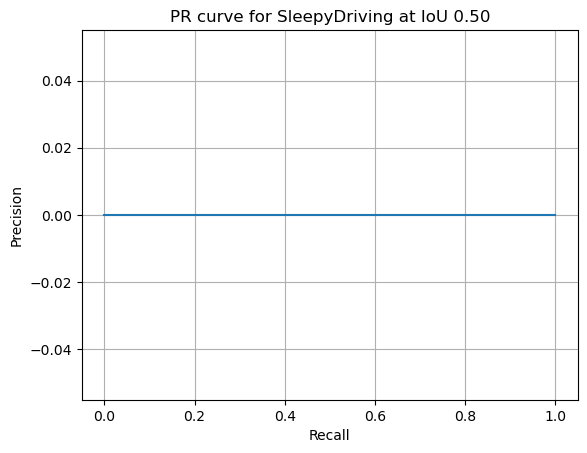

In [19]:
import matplotlib.pyplot as plt

# เลือก class name หรือ catId
target_cat = 'SleepyDriving'
k_idx = list(catId_to_name.keys()).index(next(k for k,v in catId_to_name.items() if v==target_cat))

# precision shape (T,R) for this cat
P = precision[:, :, k_idx, area_idx, maxDet_idx]  # (T, R)
# หากอยาก PR curve ที่ IoU=0.50 (first threshold often 0.5)
iou_idx = 0
prec_at_iou = P[iou_idx]  # precision values at recall thresholds
recalls = np.linspace(0, 1, prec_at_iou.shape[0])

plt.plot(recalls, prec_at_iou.clip(min=0))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR curve for {target_cat} at IoU {cocoEval.params.iouThrs[iou_idx]:.2f}')
plt.grid(True)
plt.show()


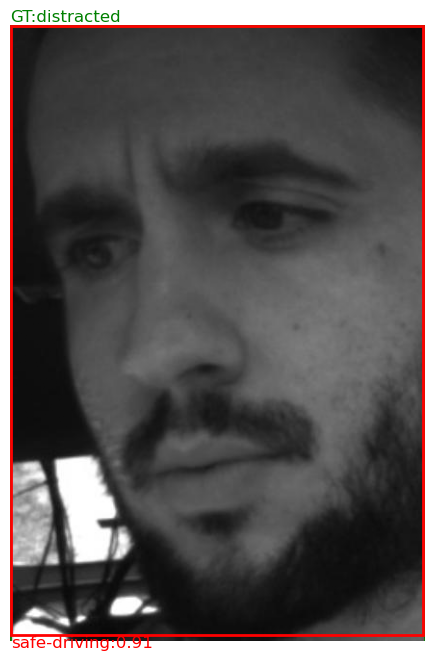

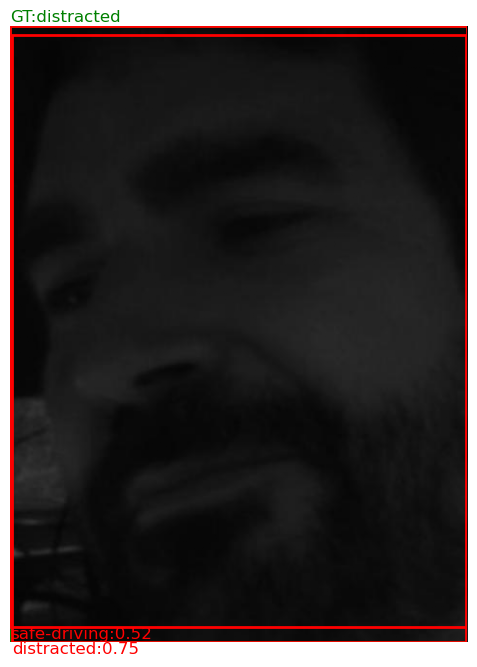

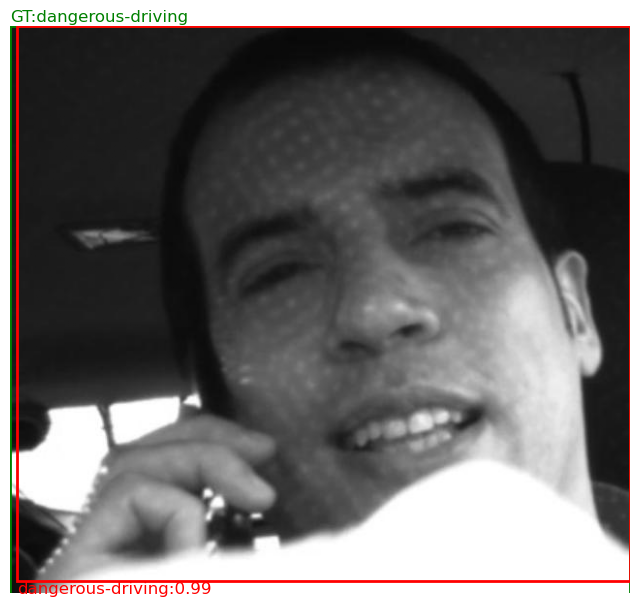

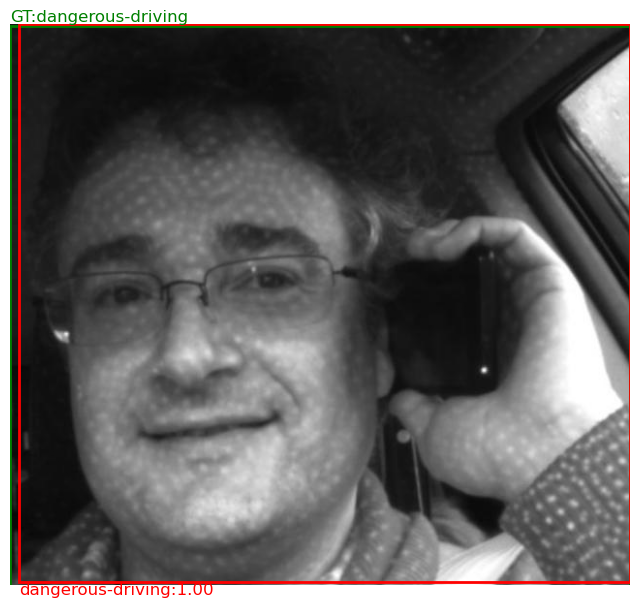

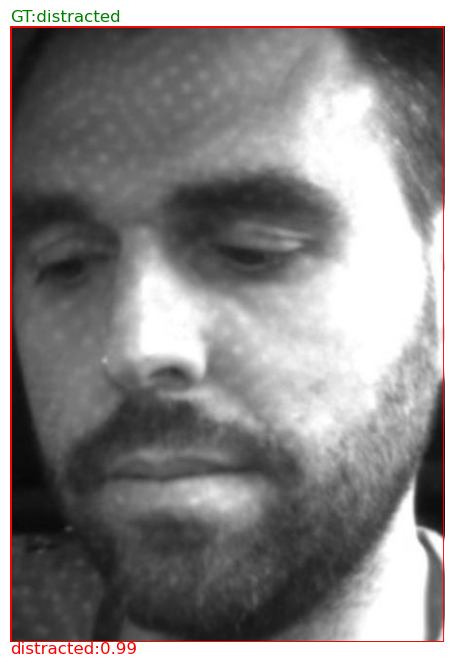

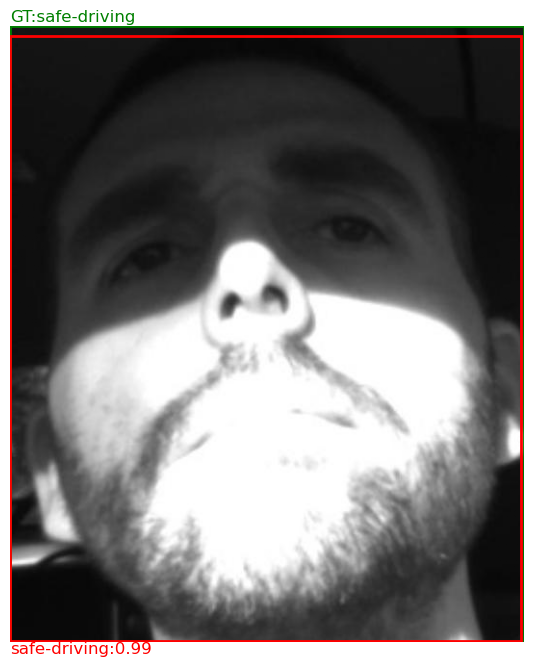

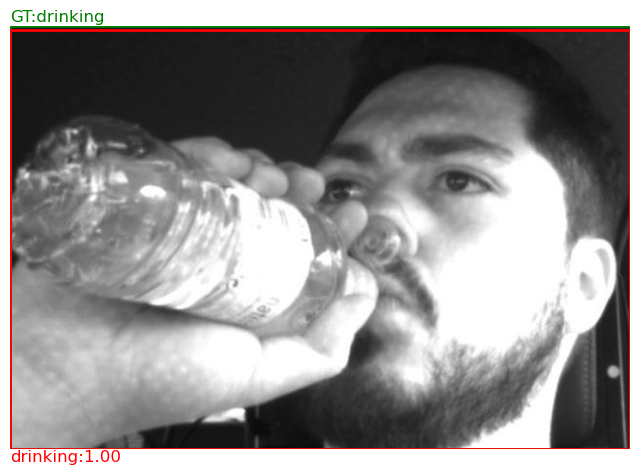

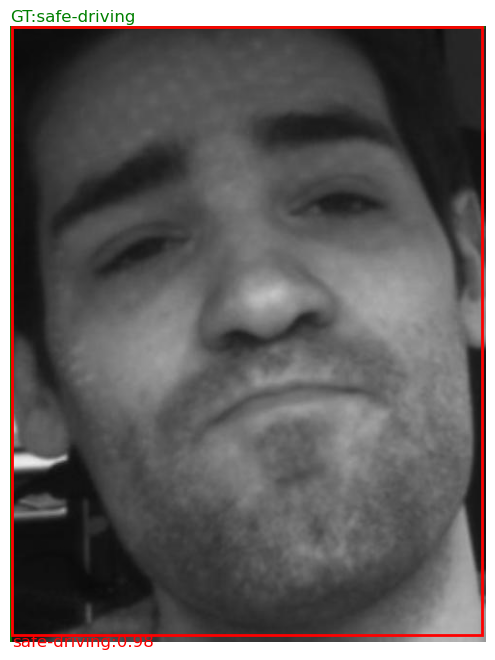

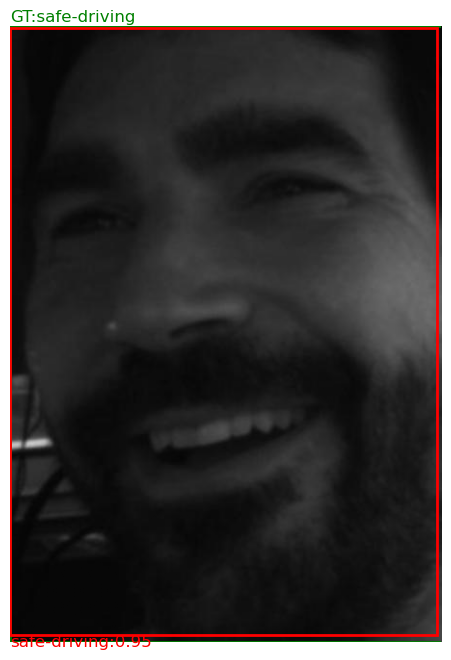

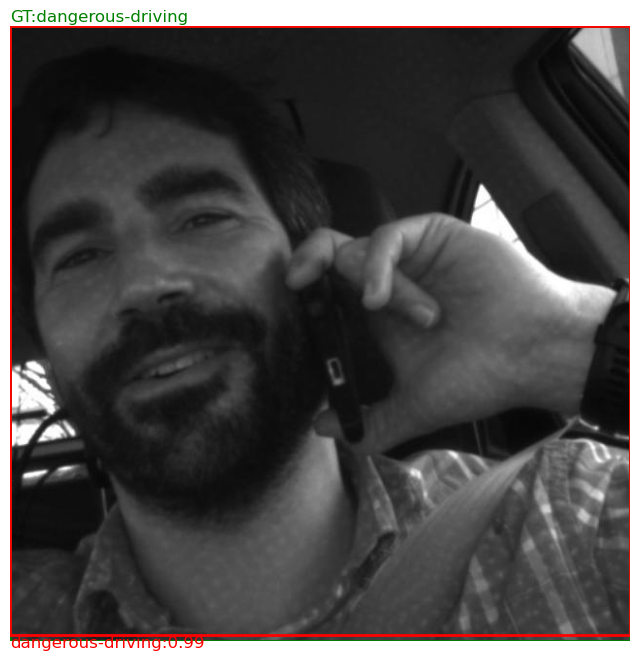

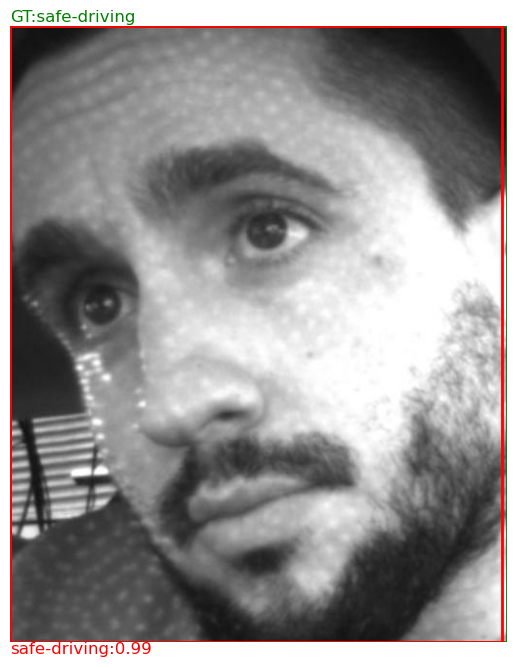

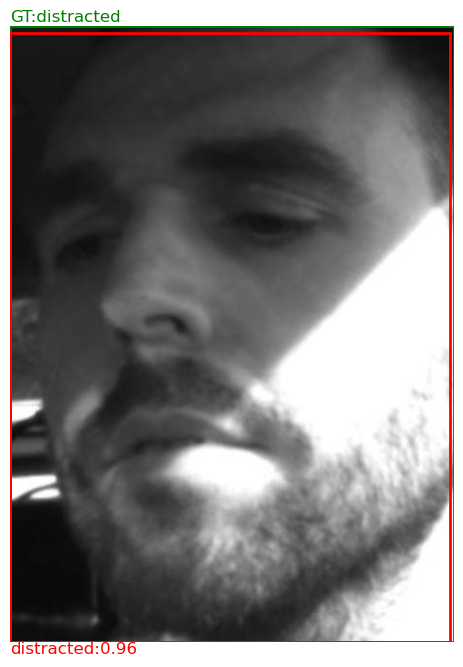

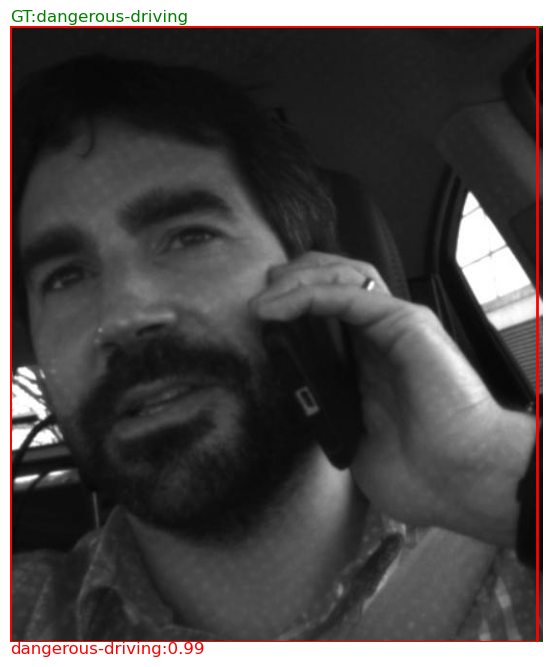

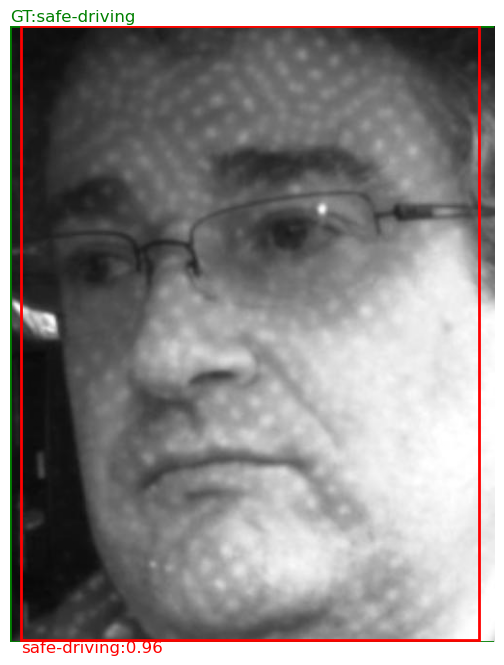

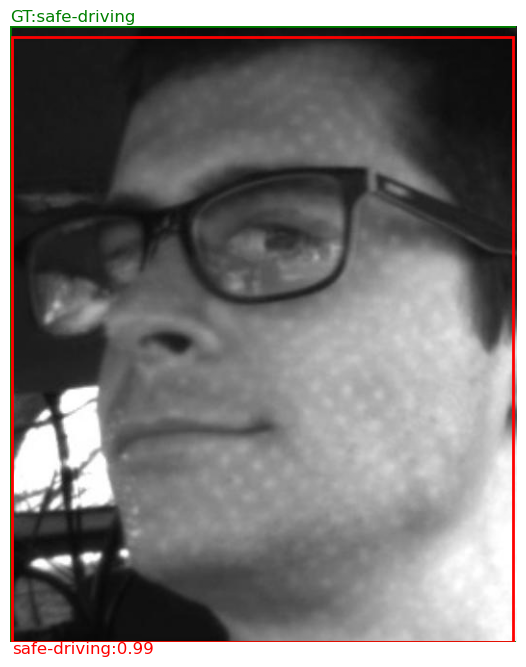

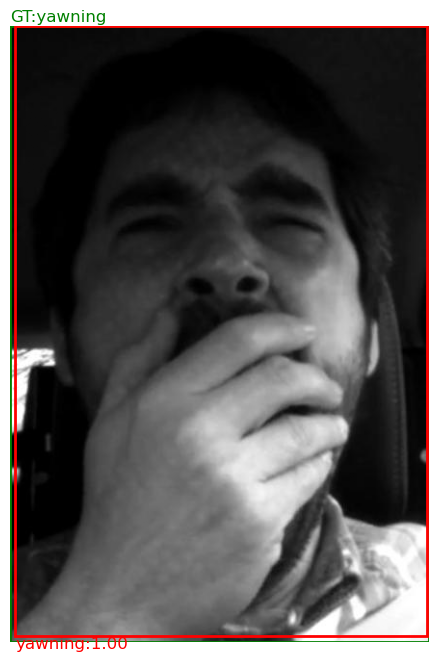

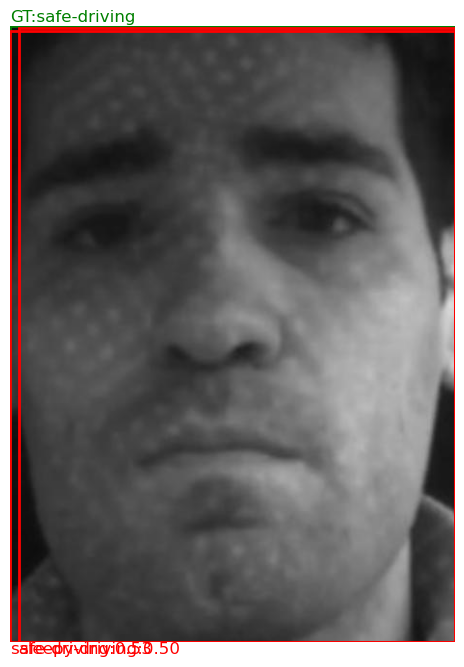

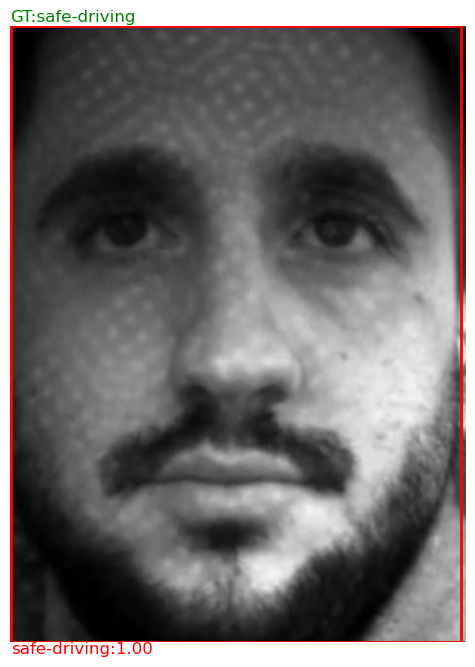

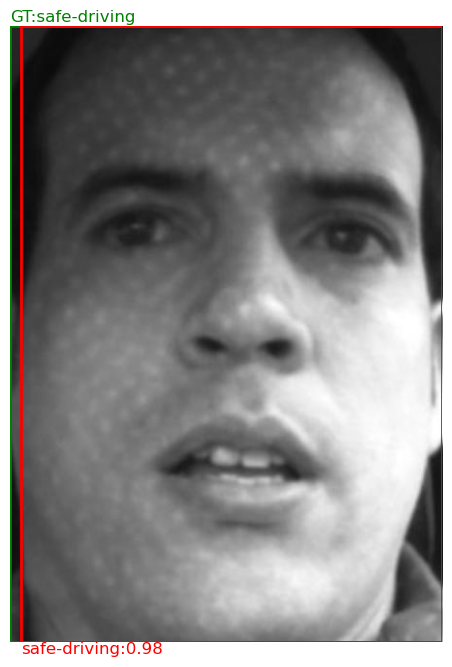

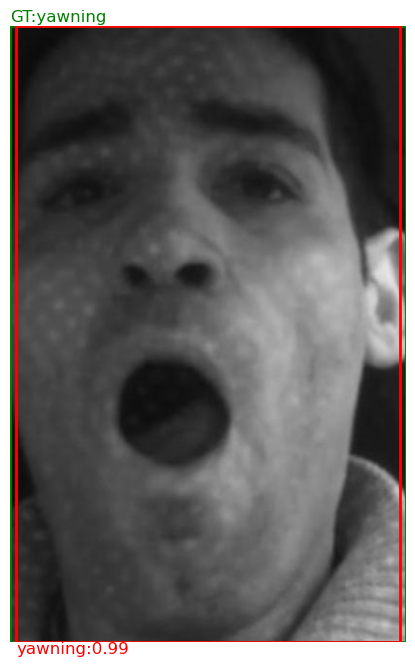

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

# ชื่อคลาสตาม dataset
categories_th = [
    "awake-or-distracted",   # 0 awake-or-distracted
    "dangerous-driving",       # 1 DangerousDriving
    "distracted",        # 2 Distracted
    "drinking",          # 3 Drinking
    "safe-driving",    # 4 SafeDriving
    "sleepy-driving",          # 5 SleepyDriving
    "yawning"            # 6 Yawn
]

# เลือกจำนวนภาพที่อยากดู
num_images_to_show = 20
pred_threshold = 0.7  # threshold ปรับได้

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, targets) in enumerate(test_loader):
        imgs = list(img.to(device) for img in imgs)
        outputs = model(imgs)

        for i, (img_tensor, target, output) in enumerate(zip(imgs, targets, outputs)):
            # Convert tensor to numpy
            img = img_tensor.permute(1, 2, 0).cpu().numpy()
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax.imshow(img)

            # Plot ground truth boxes in green
            for box, label in zip(target["boxes"], target["labels"]):
                x1, y1, x2, y2 = box.cpu().numpy()
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1-5, f"GT:{categories_th[label.item()]}", color='g', fontsize=12)

            # Plot predicted boxes in red
            for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                if score.item() >= pred_threshold:
                    x1, y1, x2, y2 = box.cpu().numpy()
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y2+12, f"{categories_th[label.item()]}:{score.item():.2f}", color='r', fontsize=12)

            plt.axis('off')
            plt.show()

            num_images_to_show -= 1
            if num_images_to_show == 0:
                break
        if num_images_to_show == 0:
            break


In [22]:
import pandas as pd
import torch
import torchvision.ops as ops

results = []

iou_threshold = 0.5  # กำหนด IoU ที่ถือว่าทายถูก
pred_threshold = 0.7  # ความมั่นใจขั้นต่ำ

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, targets) in enumerate(test_loader):
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)

        for i, (img_tensor, target, output) in enumerate(zip(imgs, targets, outputs)):
            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu()

            pred_boxes = output["boxes"].cpu()
            pred_scores = output["scores"].cpu()
            pred_labels = output["labels"].cpu()

            # กรอง predict ตาม threshold
            keep = pred_scores >= pred_threshold
            pred_boxes = pred_boxes[keep]
            pred_scores = pred_scores[keep]
            pred_labels = pred_labels[keep]

            # Matching โดยใช้ IoU
            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                ious = ops.box_iou(pred_boxes, gt_boxes)  # [num_pred, num_gt]

                for p_idx, (p_box, p_label, p_score) in enumerate(zip(pred_boxes, pred_labels, pred_scores)):
                    max_iou, gt_idx = ious[p_idx].max(dim=0)
                    gt_label = gt_labels[gt_idx].item()

                    if max_iou >= iou_threshold and p_label.item() == gt_label:
                        status = "Correct"
                    else:
                        status = "Wrong"

                    results.append({
                        "GT_Label": categories_th[gt_label],
                        "Pred_Label": categories_th[p_label.item()],
                        "IoU": round(max_iou.item(), 2),
                        "Score": round(p_score.item(), 2),
                        "Status": status
                    })

            else:
                # ไม่มี predict แต่มี GT → ทายไม่เจอ
                for gt_label in gt_labels:
                    results.append({
                        "GT_Label": categories_th[gt_label.item()],
                        "Pred_Label": "None",
                        "IoU": 0,
                        "Score": 0,
                        "Status": "Missed"
                    })

        # limit (ตัวอย่าง: 20 ภาพ)
        if len(results) > 100:
            break

# สร้างตาราง
df = pd.DataFrame(results)
print(df.head(20))


             GT_Label         Pred_Label   IoU  Score   Status
0          distracted       safe-driving  0.98   0.91    Wrong
1          distracted         distracted  0.98   0.75  Correct
2   dangerous-driving  dangerous-driving  0.97   0.99  Correct
3   dangerous-driving  dangerous-driving  0.98   1.00  Correct
4          distracted         distracted  1.00   0.99  Correct
5        safe-driving       safe-driving  0.98   0.99  Correct
6            drinking           drinking  0.99   1.00  Correct
7        safe-driving       safe-driving  0.98   0.98  Correct
8        safe-driving       safe-driving  0.98   0.95  Correct
9   dangerous-driving  dangerous-driving  0.99   0.99  Correct
10       safe-driving       safe-driving  0.99   0.99  Correct
11         distracted         distracted  0.98   0.96  Correct
12  dangerous-driving  dangerous-driving  0.99   0.99  Correct
13       safe-driving       safe-driving  0.94   0.96  Correct
14       safe-driving       safe-driving  0.97   0.99  

In [26]:
# ==============================
# 8. โหลดโมเดลที่บันทึกไว้สำหรับการใช้งานจริงบนมือถือ
# ==============================

# แปลงโมเดลเป็น TorchScript
import torch

# สร้าง dummy input 3 channels, 800x800
dummy_image = torch.rand(3, 800, 800)

# Faster R-CNN ต้องการ list ของ 3D tensor
example_input = [dummy_image]  # ใส่ [] สำคัญมาก

# ใช้ torch.jit.script ดีกว่า trace สำหรับ detection models
traced_model = torch.jit.script(model)

# บันทึก TorchScript
traced_model.save("fasterrcnn_scripted.pt")
print("Scripted model saved successfully!")



Scripted model saved successfully!
